<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BRioDeJaneiro%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://raw.githubusercontent.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/master/DadosDiarios/rjdiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,17531.0,17531.000000,6477.000000,9011.000000,8216.000000,3027.000000,8184.000000,6694.000000,6585.000000,5257.000000,0.0
mean,83743.0,579.225372,2.838984,29.086661,21.667003,5.620482,3.551894,25.047147,73.572703,1.331768,NaN
std,0.0,599.657341,9.208077,4.186300,2.802221,3.716842,1.623339,3.083081,8.879005,1.122589,NaN
min,83743.0,0.000000,0.000000,16.500000,11.100000,0.000000,0.100000,15.200000,36.250000,0.000000,NaN
25%,83743.0,0.000000,0.000000,26.000000,19.700000,1.900000,2.500000,22.840000,67.750000,0.533333,NaN
50%,83743.0,0.000000,0.000000,28.900000,21.600000,6.600000,3.300000,24.950000,74.000000,1.066667,NaN
75%,83743.0,1200.000000,0.700000,31.900000,23.800000,8.800000,4.500000,27.200000,79.750000,1.733333,NaN
max,83743.0,1200.000000,178.500000,42.000000,29.500000,12.200000,15.300000,34.000000,96.000000,10.566667,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,83743,1980-01-01,0,NaN,26.2,NaN,0.0,7.1,22.18,85.25,1.733333,NaN
1,83743,1980-01-01,1200,16.2,NaN,19.6,NaN,NaN,NaN,NaN,NaN,NaN
2,83743,1980-01-02,1200,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,83743,1980-01-04,0,NaN,26.0,NaN,10.8,4.6,23.26,74.25,4.466667,NaN
4,83743,1980-01-04,1200,0.0,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,9011.000000,0.0,3027.000000,8184.000000,6694.000000,6585.000000,5257.000000
mean,NaN,29.086661,NaN,5.620482,3.551894,25.047147,73.572703,1.331768
std,NaN,4.186300,NaN,3.716842,1.623339,3.083081,8.879005,1.122589
min,NaN,16.500000,NaN,0.000000,0.100000,15.200000,36.250000,0.000000
25%,NaN,26.000000,NaN,1.900000,2.500000,22.840000,67.750000,0.533333
50%,NaN,28.900000,NaN,6.600000,3.300000,24.950000,74.000000,1.066667
75%,NaN,31.900000,NaN,8.800000,4.500000,27.200000,79.750000,1.733333
max,NaN,42.000000,NaN,12.200000,15.300000,34.000000,96.000000,10.566667


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,6477.000000,0.0,8216.000000,0.0,0.0,0.0,0.0,0.0
mean,2.838984,NaN,21.667003,NaN,NaN,NaN,NaN,NaN
std,9.208077,NaN,2.802221,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,11.100000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,19.700000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,21.600000,NaN,NaN,NaN,NaN,NaN
75%,0.700000,NaN,23.800000,NaN,NaN,NaN,NaN,NaN
max,178.500000,NaN,29.500000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,26.2,0.0,7.1,22.18,85.25,1.733333
1980-01-04,26.0,10.8,4.6,23.26,74.25,4.466667
1980-01-06,27.3,12.1,5.4,24.80,70.25,4.233333
1980-01-07,30.7,9.4,3.5,26.24,74.25,3.533333
1980-01-09,31.8,9.1,4.5,27.92,69.50,4.066667


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,16.2,19.6
1980-01-02,1.4,NaN
1980-01-04,0.0,20.0
1980-01-05,0.0,NaN
1980-01-06,0.0,21.5


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,26.2,0.0,7.1,22.18,85.25,1.733333,16.2,19.6
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,1.4,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,26.0,10.8,4.6,23.26,74.25,4.466667,0.0,20.0
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,9011.000000,3027.000000,8184.000000,6694.000000,6585.000000,5257.000000,6477.000000,8216.000000
mean,29.086661,5.620482,3.551894,25.047147,73.572703,1.331768,2.838984,21.667003
std,4.186300,3.716842,1.623339,3.083081,8.879005,1.122589,9.208077,2.802221
min,16.500000,0.000000,0.100000,15.200000,36.250000,0.000000,0.000000,11.100000
25%,26.000000,1.900000,2.500000,22.840000,67.750000,0.533333,0.000000,19.700000
50%,28.900000,6.600000,3.300000,24.950000,74.000000,1.066667,0.000000,21.600000
75%,31.900000,8.800000,4.500000,27.200000,79.750000,1.733333,0.700000,23.800000
max,42.000000,12.200000,15.300000,34.000000,96.000000,10.566667,178.500000,29.500000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,26.2,0.0,7.1,22.18,85.25,1.733333,16.2,19.6
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,1.4,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,26.0,10.8,4.6,23.26,74.25,4.466667,0.0,20.0
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-01,0.0,7.1,22.18,85.25,1.733333,16.2,19.6
1980-01-04,10.8,4.6,23.26,74.25,4.466667,0.0,20.0
1980-01-06,12.1,5.4,24.80,70.25,4.233333,0.0,21.5
1980-01-07,9.4,3.5,26.24,74.25,3.533333,0.0,21.5
1980-01-09,9.1,4.5,27.92,69.50,4.066667,0.0,24.2


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-01    26.2
1980-01-04    26.0
1980-01-06    27.3
1980-01-07    30.7
1980-01-09    31.8
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,3027.000000,8177.000000,6693.000000,6583.000000,5201.000000,6229.000000,8210.000000
mean,-0.078609,-0.545835,0.047554,0.249337,-0.747339,-0.967422,0.148567
std,0.609318,0.213655,0.328010,0.297189,0.213106,0.104756,0.304633
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.688525,-0.684211,-0.187234,0.054393,-0.899054,-1.000000,-0.065217
50%,0.081967,-0.578947,0.036170,0.263598,-0.798107,-1.000000,0.141304
75%,0.442623,-0.421053,0.276596,0.456067,-0.671924,-0.991036,0.380435
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(9011, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 684.8189 - mean_absolute_error: 25.7681
Epoch 2/200
 - 1s - loss: 442.2183 - mean_absolute_error: 20.5752
Epoch 3/200
 - 1s - loss: 285.7618 - mean_absolute_error: 16.3524
Epoch 4/200
 - 1s - loss: 176.7705 - mean_absolute_error: 12.5811
Epoch 5/200
 - 1s - loss: 103.8605 - mean_absolute_error: 9.2802
Epoch 6/200
 - 1s - loss: 58.5510 - mean_absolute_error: 6.5401
Epoch 7/200
 - 1s - loss: 33.7709 - mean_absolute_error: 4.6884
Epoch 8/200
 - 1s - loss: 22.3575 - mean_absolute_error: 3.7534
Epoch 9/200
 - 1s - loss: 18.3741 - mean_absolute_error: 3.4288
Epoch 10/200
 - 1s - loss: 17.4170 - mean_absolute_error: 3.3571
Epoch 11/200
 - 1s 

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -2.590809, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-2.590809 (0.134770) {'batch_size': 10, 'camadas': 2, 'units': 7}


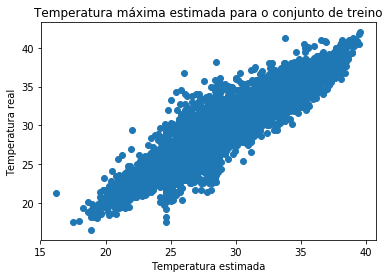

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.92680375]
 [0.92680375 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

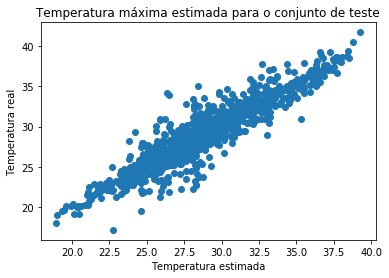

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.92358426]
 [0.92358426 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

1.1811385655878919


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

2.732329392178574


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-01,26.2,0.0,7.1,22.18,85.25,1.733333,16.2
1980-01-04,26.0,10.8,4.6,23.26,74.25,4.466667,0.0
1980-01-06,27.3,12.1,5.4,24.80,70.25,4.233333,0.0
1980-01-07,30.7,9.4,3.5,26.24,74.25,3.533333,0.0
1980-01-09,31.8,9.1,4.5,27.92,69.50,4.066667,0.0


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-01    19.6
1980-01-04    20.0
1980-01-06    21.5
1980-01-07    21.5
1980-01-09    24.2
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,8210.000000,2233.000000,8176.000000,6692.000000,6583.000000,5200.000000,6231.000000
mean,0.000061,-0.097715,-0.545729,0.047659,0.249259,-0.747420,-0.967424
std,0.331332,0.607159,0.213600,0.327935,0.297243,0.213146,0.104742
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.239216,-0.721311,-0.684211,-0.187234,0.050209,-0.899054,-1.000000
50%,-0.011765,0.049180,-0.578947,0.037234,0.263598,-0.798107,-1.000000
75%,0.223529,0.426230,-0.421053,0.276596,0.456067,-0.671924,-0.991036
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(8216, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 359.7239 - mean_absolute_error: 18.6767
Epoch 2/200
 - 1s - loss: 203.4962 - mean_absolute_error: 13.9501
Epoch 3/200
 - 1s - loss: 114.6497 - mean_absolute_error: 10.2968
Epoch 4/200
 - 1s - loss: 60.4413 - mean_absolute_error: 7.2347
Epoch 5/200
 - 1s - loss: 30.0716 - mean_absolute_error: 4.8024
Epoch 6/200
 - 1s - loss: 15.3704 - mean_absolute_error: 3.2356
Epoch 7/200
 - 1s - loss: 9.6327 - mean_absolute_error: 2.5235
Epoch 8/200
 - 1s - loss: 7.9932 - mean_absolute_error: 2.3234
Epoch 9/200
 - 1s - loss: 7.6837 - mean_absolute_error: 2.2849
Epoch 10/200
 - 1s - loss: 7.6506 - mean_absolute_error: 2.2825
Epoch 11/200
 - 1s - loss: 7.6500 - mean_absolute_error: 2.2824
Epoch 12/200
 - 1s - loss: 7.6518 - mean_absolute_error: 2.2829
Epoch 13/200
 - 1s

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -1.146915, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-1.146915 (0.073677) {'batch_size': 10, 'camadas': 2, 'units': 7}


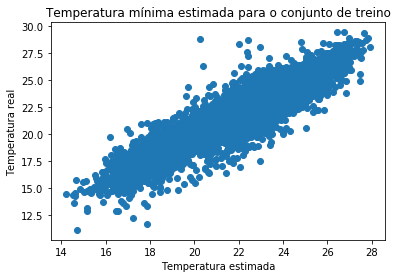

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.93202557]
 [0.93202557 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

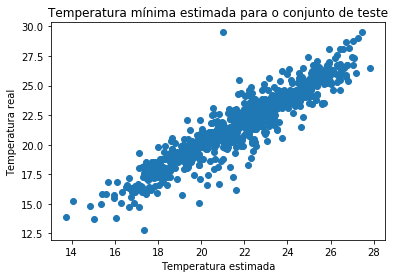

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.93073666]
 [0.93073666 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.7656818821482416


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

1.192180394186469


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaRioDeJaneiro.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaRioDeJaneiro.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))